# **Implementation of Seq2Seq network for English to French Translation**

In this tutorial, we implement a Seq2Seq model to translate English sentences into French. The Seq2Seq architecture is widely used for tasks like language translation, text summarization, and conversational AI. We will walk through each step, from data preparation to building and evaluating the model, focusing on understanding the process and principles behind this powerful architecture

# Step1: Download Data

In [ ]:
import kagglehub
import os
import pandas as pd

# Step 1: Download the dataset
path = kagglehub.dataset_download("devicharith/language-translation-englishfrench")

# Step 2: List the files in the dataset directory
print("\nFiles in the dataset directory:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(file)

# Step 3: If the dataset contains a CSV file, load it and check the column names
# Assume the file is named 'english_french.csv' or similar (you can adjust based on the actual file name)
csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

for csv_file in csv_files:
    file_path = os.path.join(path, csv_file)
    df = pd.read_csv(file_path)

    # Step 4: Print the first few rows and column names
    print(f"\nInspecting {csv_file}...")
    print("Columns:", df.columns)
    print(df.head())


100%|██████████| 3.51M/3.51M [00:00<00:00, 5.38MB/s]

Extracting files...



Files in the dataset directory:
eng_-french.csv

Inspecting eng_-french.csv...
Columns: Index(['English words/sentences', 'French words/sentences'], dtype='object')
  English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !


# Step2: Data Preprocessing

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Data Preprocessing: Clean text (e.g., lowercasing, punctuation removal)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespaces
    return text
df = df.sample(n=10000, random_state=42)
# Apply cleaning function to both English and French sentences
df['English words/sentences'] = df['English words/sentences'].apply(clean_text)
df['French words/sentences'] = df['French words/sentences'].apply(clean_text)

# Split the data into training and testing sets
X = df['English words/sentences'].values
y = df['French words/sentences'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training data
print(f"Training data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")

Training data size: 8000
Test data size: 2000


# Step 3: Tokenaization and Padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizers for English and French
english_tokenizer = Tokenizer()
french_tokenizer = Tokenizer()

# Fit the tokenizers on the training data
english_tokenizer.fit_on_texts(X_train)
french_tokenizer.fit_on_texts(y_train)

# Convert sentences to sequences
X_train_seq = english_tokenizer.texts_to_sequences(X_train)
y_train_seq = french_tokenizer.texts_to_sequences(y_train)

X_test_seq = english_tokenizer.texts_to_sequences(X_test)
y_test_seq = french_tokenizer.texts_to_sequences(y_test)

# Pad the sequences to ensure uniform length
max_input_len = max([len(seq) for seq in X_train_seq])
max_output_len = max([len(seq) for seq in y_train_seq])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_input_len, padding='post')
y_train_pad = pad_sequences(y_train_seq, maxlen=max_output_len, padding='post')

X_test_pad = pad_sequences(X_test_seq, maxlen=max_input_len, padding='post')
y_test_pad = pad_sequences(y_test_seq, maxlen=max_output_len, padding='post')

# Check the shape of padded sequences
print(f"Shape of X_train_pad: {X_train_pad.shape}")
print(f"Shape of y_train_pad: {y_train_pad.shape}")


Shape of X_train_pad: (8000, 32)
Shape of y_train_pad: (8000, 40)


# Steo 4: Seq2Seq Model Building

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Parameters
embedding_dim = 256
latent_dim = 512

# Define the encoder
encoder_input = Input(shape=(max_input_len,))
encoder_embedding = Embedding(input_dim=len(english_tokenizer.word_index) + 1, output_dim=embedding_dim)(encoder_input)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)

# Define the decoder
decoder_input = Input(shape=(max_output_len,))
decoder_embedding = Embedding(input_dim=len(french_tokenizer.word_index) + 1, output_dim=embedding_dim)(decoder_input)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_dense = TimeDistributed(Dense(len(french_tokenizer.word_index) + 1, activation='softmax'))
decoder_output = decoder_dense(decoder_output)

# Build the model
model = Model([encoder_input, decoder_input], decoder_output)
# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Display the model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 32, 256)        │      1,094,656 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 40, 256)        │      1,735,936 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 512), (None,   │      1,574,912 │ embedding[0][0]        │
│                           │ 512), (None, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 40, 512),      │      1,574,912 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 40, 6781)       │      3,478,653 │ lstm_1[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,459,069 (36.08 MB)

 Trainable params: 9,459,069 (36.08 MB)

 Non-trainable params: 0 (0.00 B)

# Step 5: Model Training

In [ ]:
# Prepare decoder input for training
y_train_decoder_input = np.zeros_like(y_train_pad)
y_train_decoder_input[:, 1:] = y_train_pad[:, :-1]

y_train_decoder_input = y_train_decoder_input.reshape((y_train_decoder_input.shape[0], y_train_decoder_input.shape[1], 1))

# Train the model
history = model.fit(
    [X_train_pad, y_train_decoder_input],
    np.expand_dims(y_train_pad, -1),  # Add an extra dimension for the target sequence
    epochs=10,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 786ms/step - accuracy: 0.7908 - loss: 2.7032 - val_accuracy: 0.8417 - val_loss: 1.1362
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 764ms/step - accuracy: 0.8412 - loss: 1.1085 - val_accuracy: 0.8438 - val_loss: 1.1035
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 770ms/step - accuracy: 0.8410 - loss: 1.0674 - val_accuracy: 0.8453 - val_loss: 1.0738
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 761ms/step - accuracy: 0.8449 - loss: 1.0138 - val_accuracy: 0.8472 - val_loss: 1.0461
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 761ms/step - accuracy: 0.8477 - loss: 0.9693 - val_accuracy: 0.8509 - val_loss: 1.0200
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 751ms/step - accuracy: 0.8521 - loss: 0.9241 - val_accuracy: 0.8535 - val_loss: 0.9999
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 754ms/step - accuracy: 0.8545 - loss: 0.8848 - val_accuracy: 0.8551 - val_loss: 0.9817
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 751ms/step - accuracy: 0.8562 - loss: 0

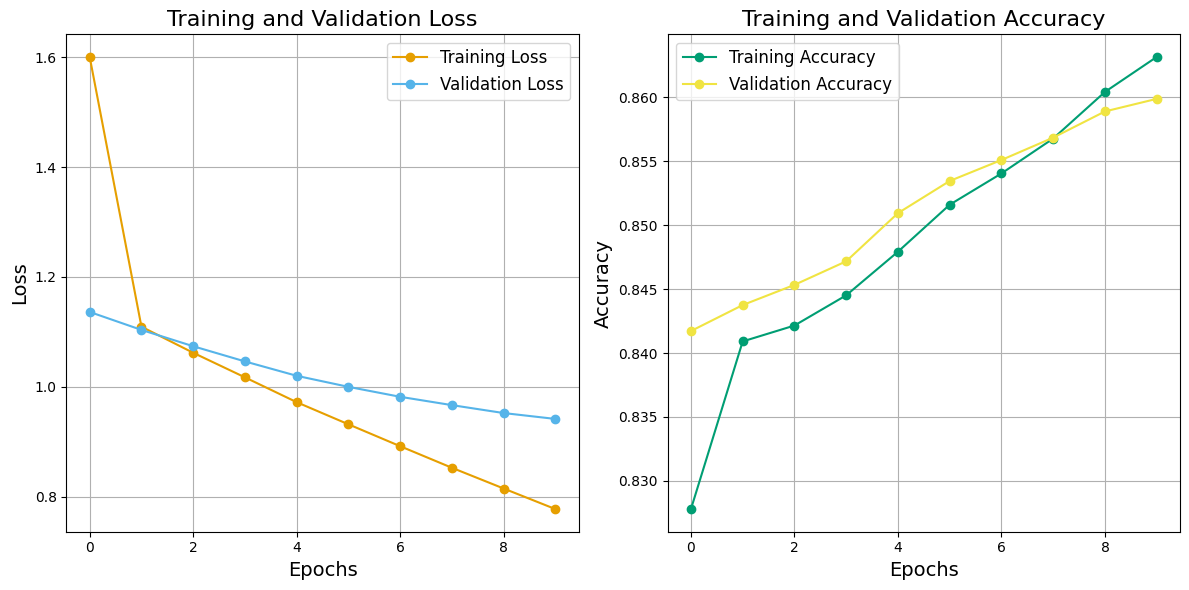

In [ ]:
import matplotlib.pyplot as plt

# Define color-blind friendly colors (using a simple palette)
color_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']

# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o', color=color_palette[0])  # Training Loss
plt.plot(val_loss, label='Validation Loss', marker='o', color=color_palette[1])  # Validation Loss
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy', marker='o', color=color_palette[2])  # Training Accuracy
plt.plot(val_accuracy, label='Validation Accuracy', marker='o', color=color_palette[3])  # Validation Accuracy
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()



# Step 6: Inference

In [ ]:
# Prepare decoder input for testing
y_test_decoder_input = np.zeros_like(y_test_pad)
y_test_decoder_input[:, 1:] = y_test_pad[:, :-1]

# Reshape the decoder input to match the expected shape
y_test_decoder_input = y_test_decoder_input.reshape((y_test_decoder_input.shape[0], y_test_decoder_input.shape[1], 1))


In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(
    [X_test_pad, y_test_decoder_input],  # Encoder input and decoder input
    np.expand_dims(y_test_pad, -1)       # Decoder target output (expanded to match expected shape)
)

print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8619 - loss: 0.8532
Test Loss: 0.846774160861969, Test Accuracy: 0.8630124926567078


In [ ]:
# Function to convert a sequence of indices back to sentence using the tokenizer
def convert_idx_to_sent(input_seq, tokenizer):
    sent = ''
    for idx in input_seq:
        if idx != 0:  # Skip padding tokens
            sent += tokenizer.index_word[idx] + ' '
    return sent.strip()

# Function to translate new English sentences
def translate(input_sentence):
    # Convert the input sentence into sequence
    input_seq = english_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')

    # Start with an initial decoder input sequence (e.g., all zeros)
    decoder_input_seq = np.zeros((1, max_output_len))

    # Store the translated sentence
    decoded_sentence = ''

    # Predict the output sequence (French translation)
    for t in range(max_output_len):
        output_tokens = model.predict([input_seq, decoder_input_seq])

        # Get the token with the highest probability for the current timestep
        sampled_token_index = np.argmax(output_tokens[0, t, :])
        sampled_word = french_tokenizer.index_word.get(sampled_token_index, '')

        # Add the word to the decoded sentence
        decoded_sentence += ' ' + sampled_word

        # Update the decoder input for the next timestep (autoregressive)
        decoder_input_seq[0, t] = sampled_token_index

        # If we encounter the <end> token, we stop the prediction
        if sampled_word == '<end>':
            break

    return decoded_sentence.strip()

# Example usage of the translate function:
input_sentence = "Hi."
translated_sentence = translate(input_sentence)
print(f"Translated: {translated_sentence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [ ]:
# Evaluate the model's predictions on the test data
test_predictions = model.predict([X_test_pad, y_test_decoder_input])

# Convert predicted sequences to words
pred_fra_text = [convert_idx_to_sent(np.argmax(pred, axis=1), french_tokenizer) for pred in test_predictions]

# Convert actual French sequences to words (use tokenized data, not raw text)
orig_fra_text = [convert_idx_to_sent(seq, french_tokenizer) for seq in y_test_pad]

# Show the results
predictions = pd.DataFrame({
    'Original English Sentence': [convert_idx_to_sent(seq, english_tokenizer) for seq in X_test_pad],
    'Original French Sentence': orig_fra_text,
    'Predicted French Sentence': pred_fra_text
})

# Display the first few predictions
print(predictions.head())


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
                           Original English Sentence  \
0                       he is eager to become famous   
1                              that's very dishonest   
2  tom was able to do what the rest of us weren't...   
3            everybody took a attitude toward aliens   
4                              my father is a doctor   

                            Original French Sentence  \
0                                    il est avide de   
1                              c'est très malhonnête   
2  tom fut capable de faire ce que nous autres ét...   
3     tout le monde a adopté une attitude envers les   
4                                       mon père est   

                      Predicted French Sentence  
0                                  je a un à la  
1                                    je un très  
2        je a un de ne la que je ne pas à faire  
3  je vous monde a été une voiture de la maison  
4                             je chi